In [1]:
import numpy as np
import shapely
import bisect
import shapely.wkt
import matplotlib.pyplot as plt
import math
import geopandas as gpd
import json
import pandas as pd
import seaborn as sns
from enum import Enum


from bench_utils import parse_intersection_data 

In [2]:
# Geometries
manual_data, _ = parse_intersection_data("manual")
special_cases, _ = parse_intersection_data("latest_export.json", strip_precision=True)
world_data, world_data_stats = parse_intersection_data("world.json", 10, strip_precision=False)
lund_data, lund_data_stats = parse_intersection_data("lund.json", 100)

In [3]:
SHOW_COORDINATES = True
SHOW_GEOMETRIES = True
SHOW_INTERSECTING_POINTS = True
SHOW_COMMON_BOUNDING_BOX = False
SHOW_BOUNDING_BOXES = False
SHOW_STATS = True

LARGE_THRESHOLD = 50


In [4]:
import intersection.first_bin_search
import intersection.chunk_bbox_intersection
binary_intersection = intersection.first_bin_search.binary_intersection
chunk_bbox_is_intersecting = intersection.chunk_bbox_intersection.is_intersecting
chunk_bbox_intersection = intersection.chunk_bbox_intersection.intersection

from intersection.plotting import *


from algos.alg_fpd_extended import FpdExtended
fpd = FpdExtended()

/Users/leowesterberg/Examensarbete/intersection/plotting.py:129: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


KeyboardInterrupt: 

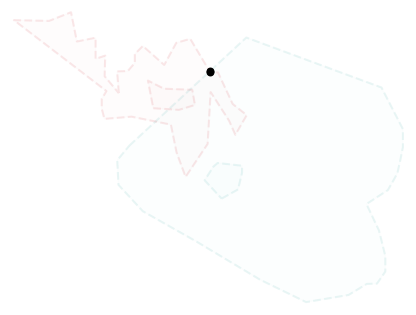

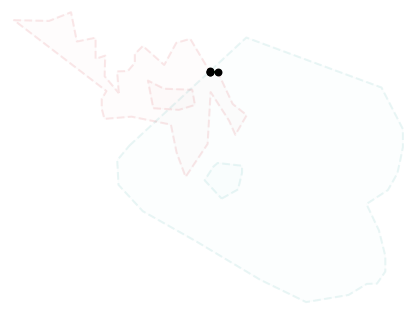

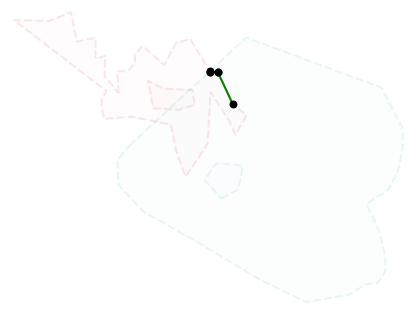

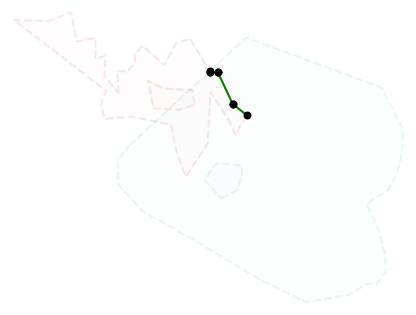

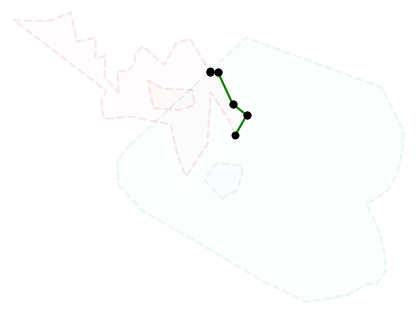

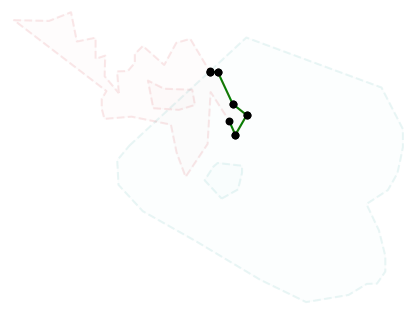

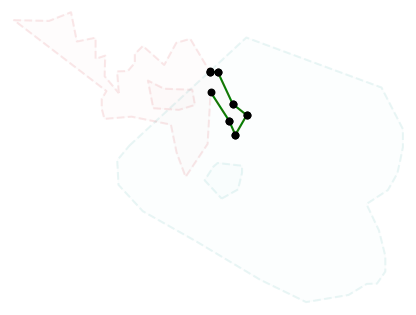

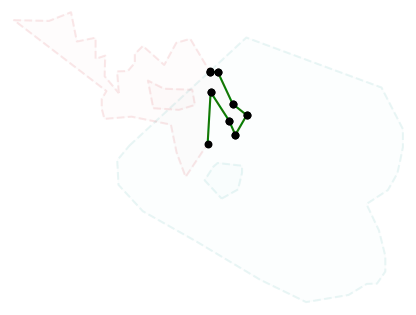

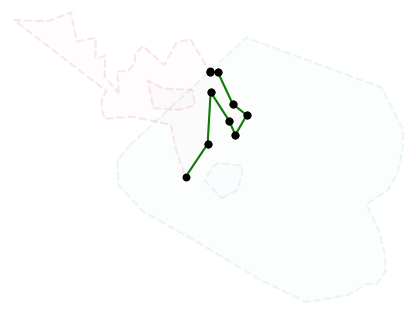

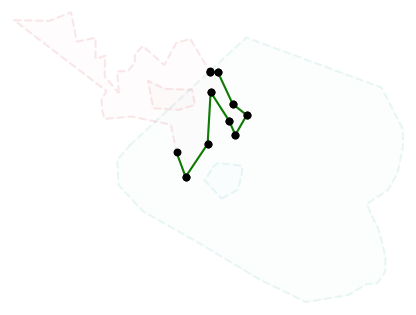

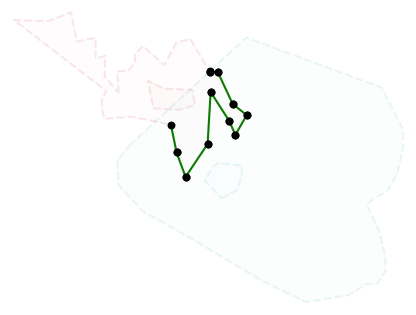

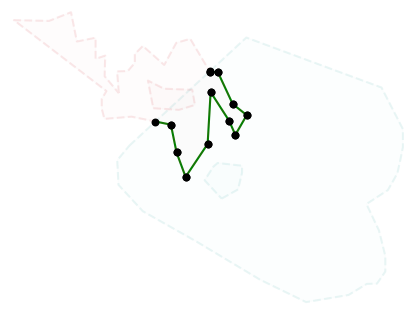

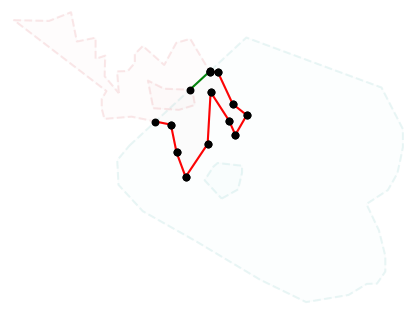

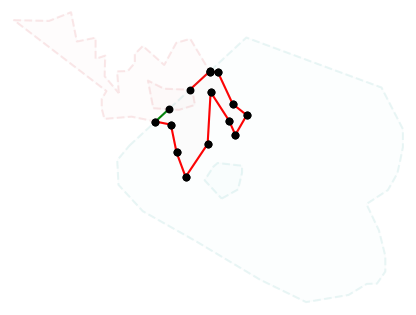

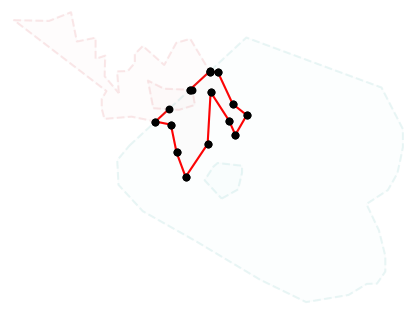

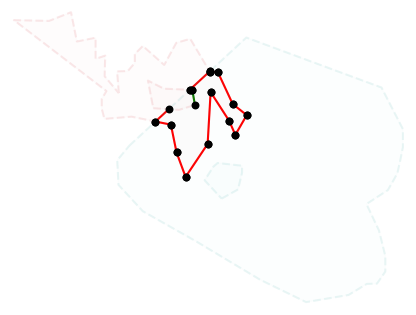

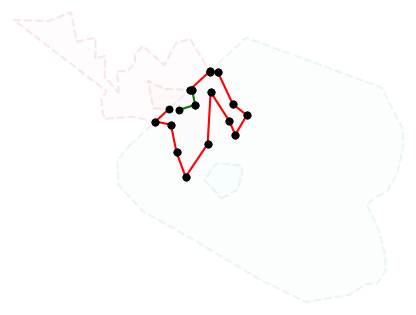

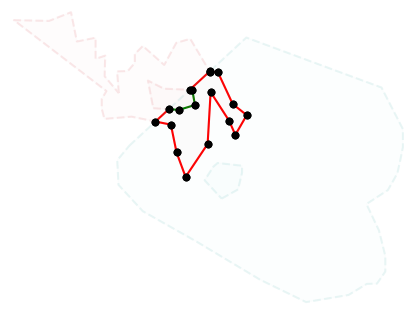

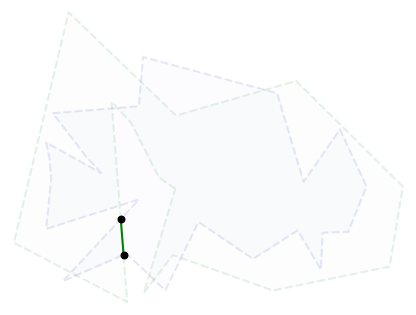

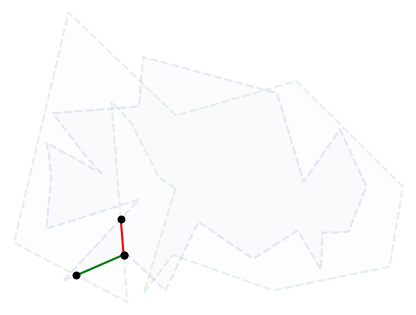

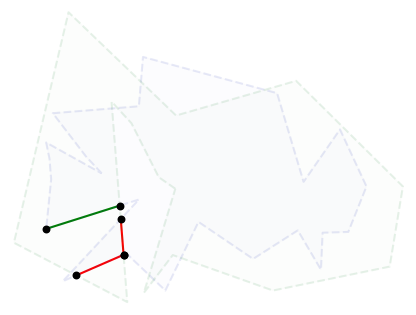

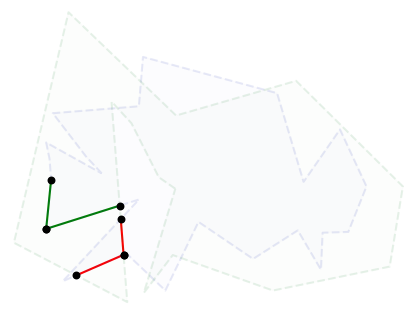

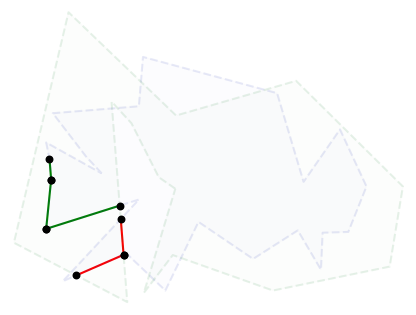

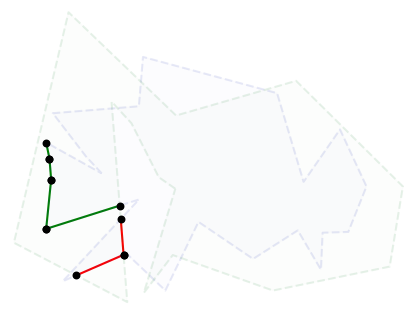

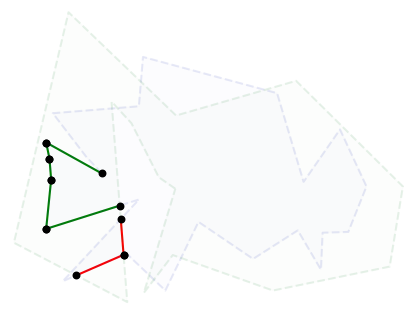

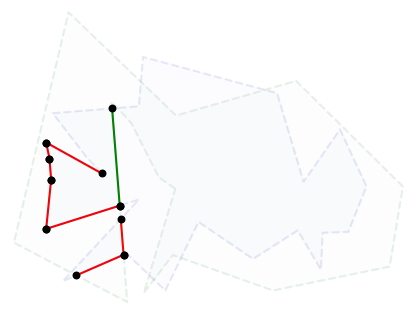

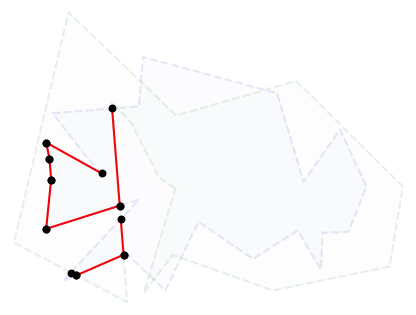

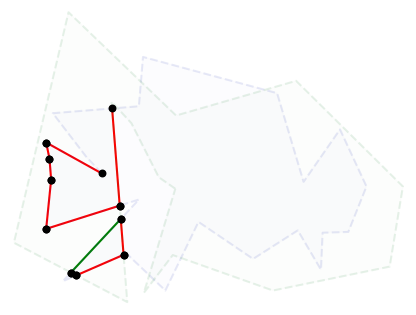

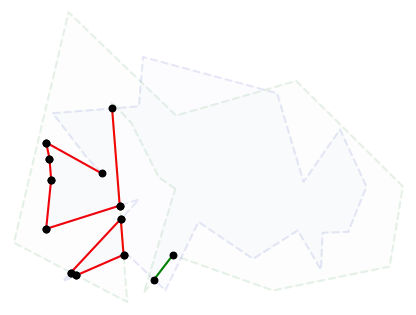

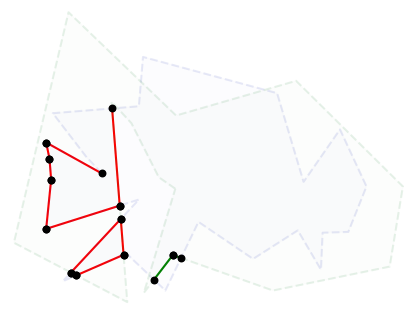

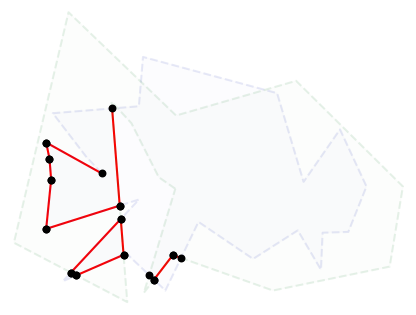

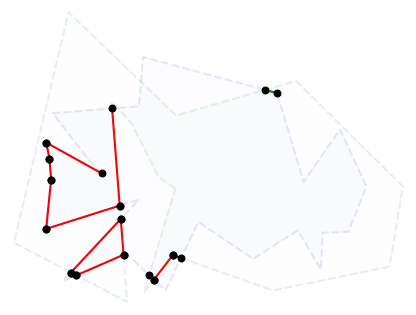

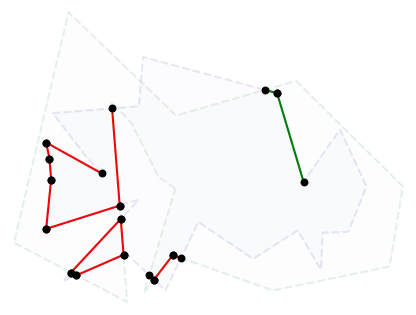

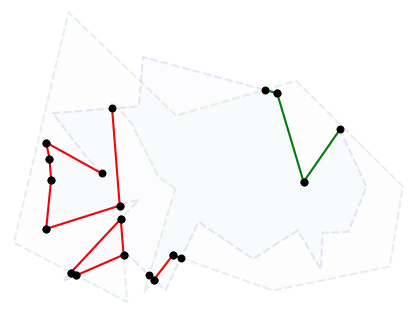

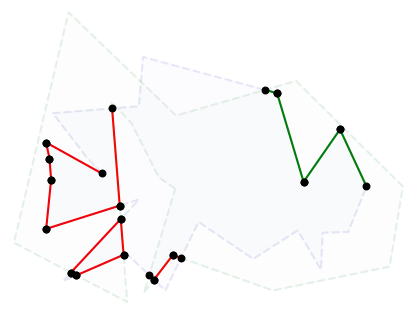

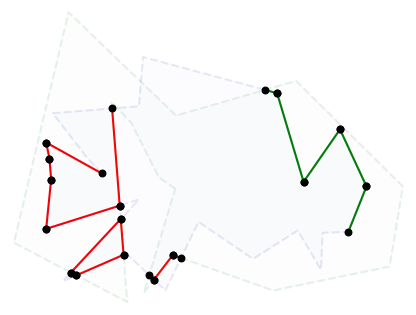

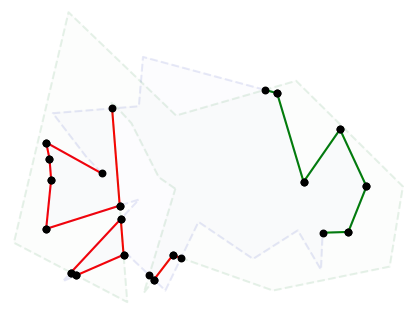

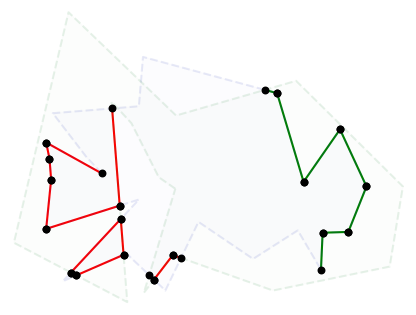

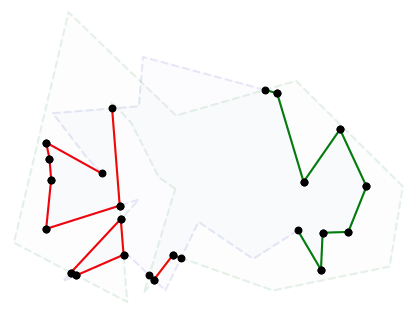

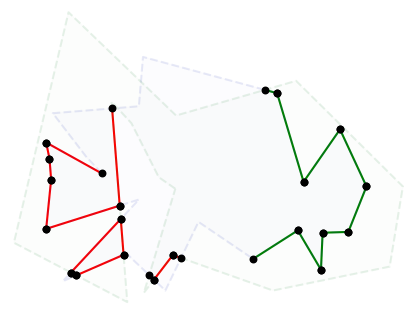

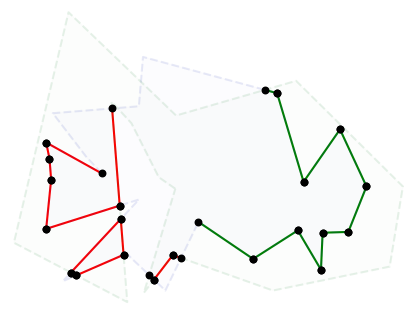

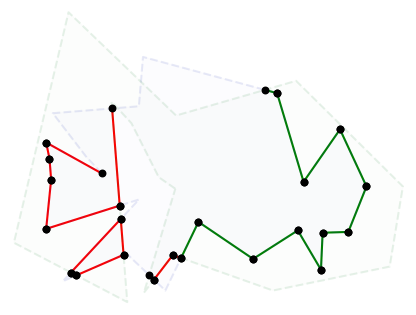

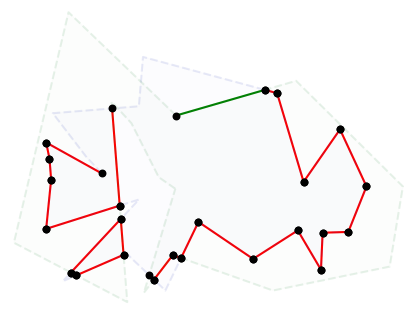

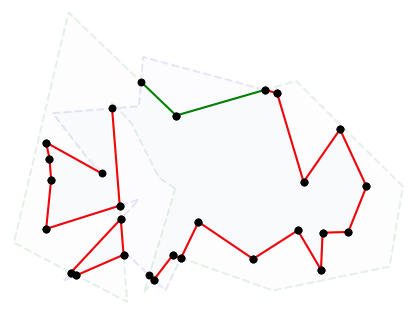

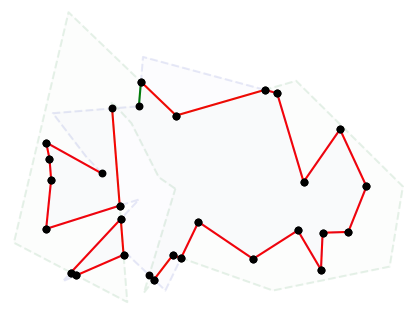

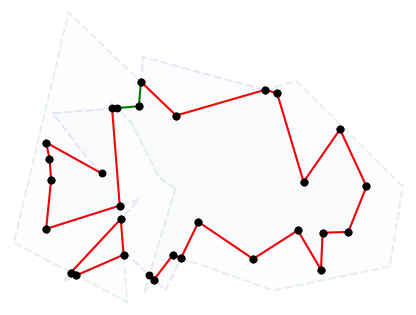

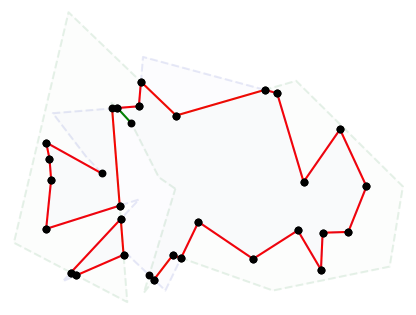

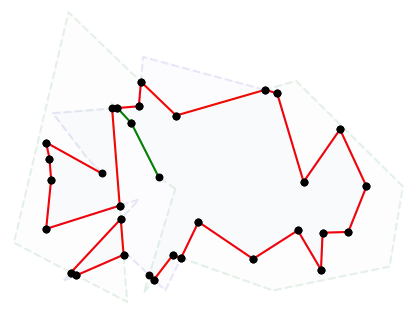

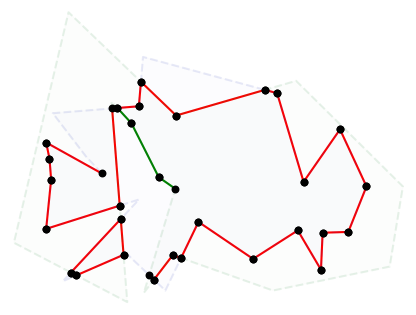

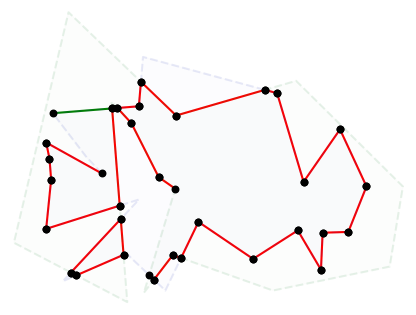

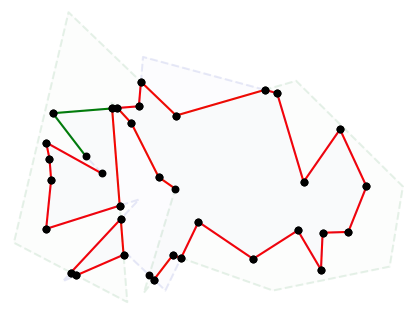

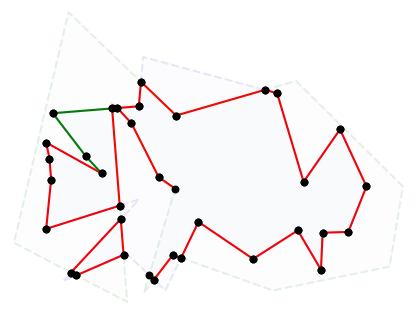

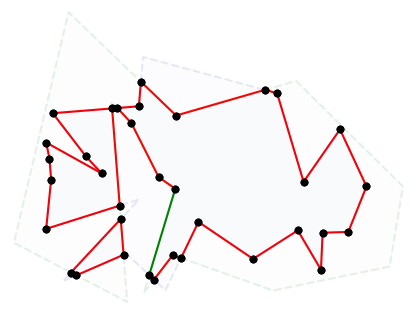

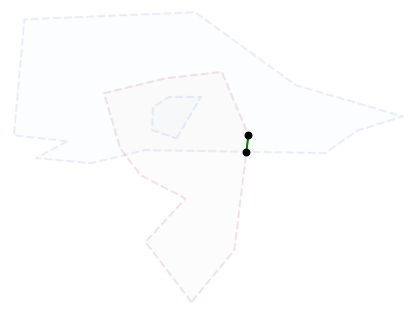

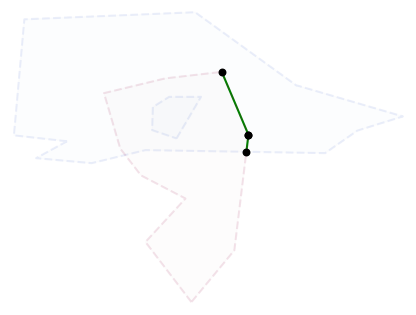

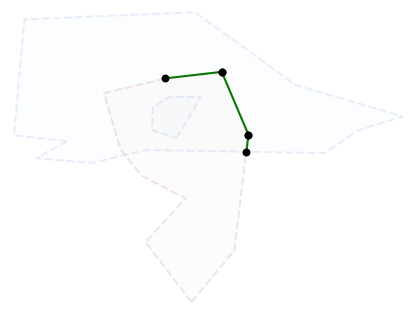

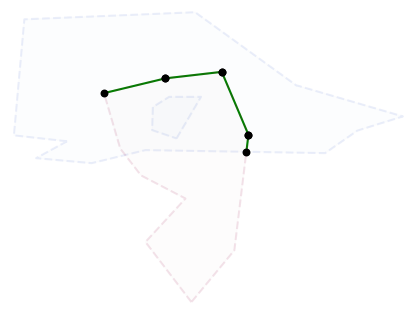

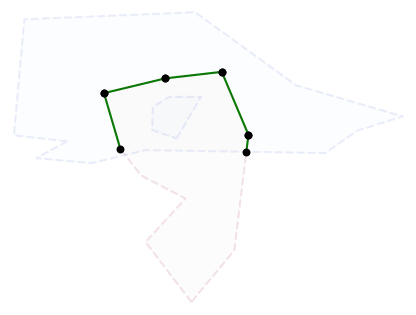

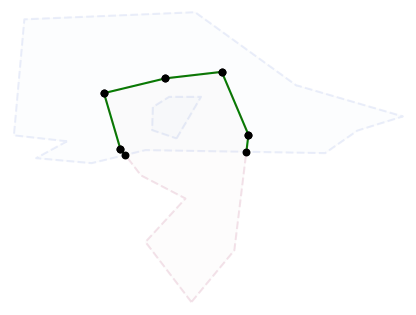

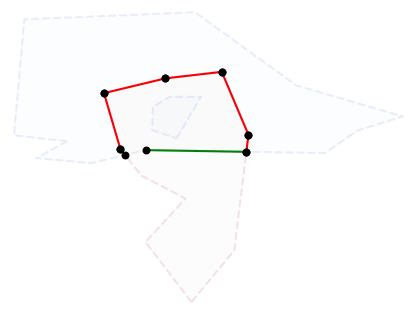

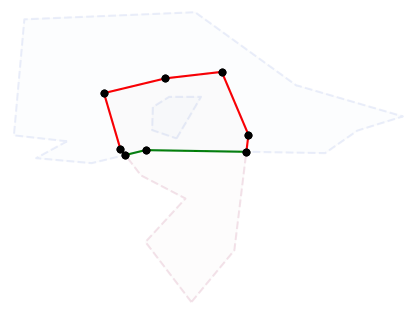

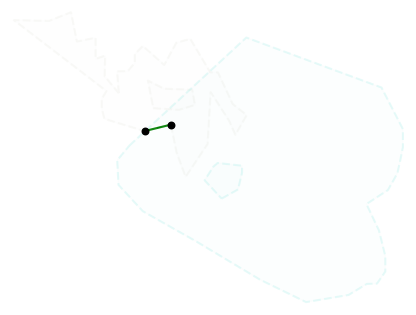

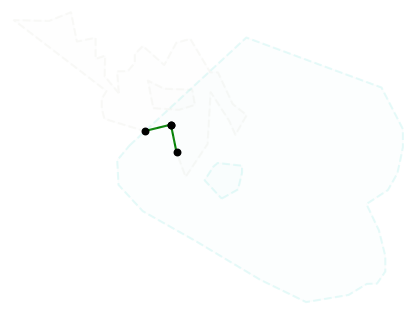

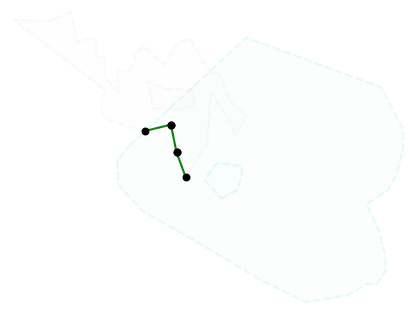

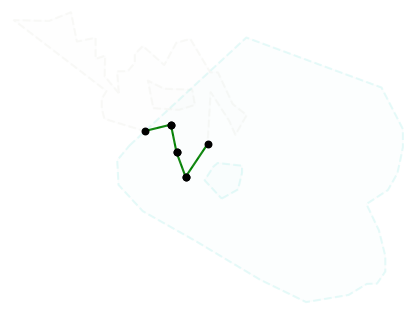

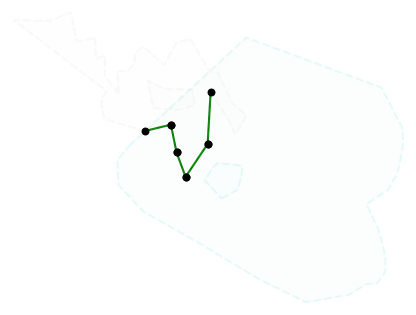

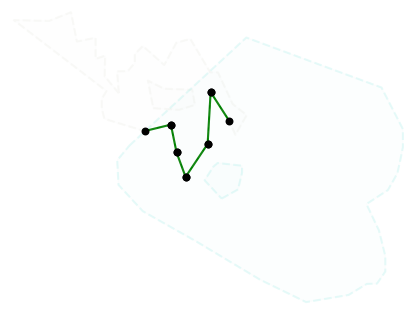

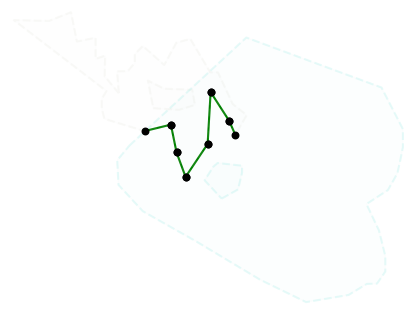

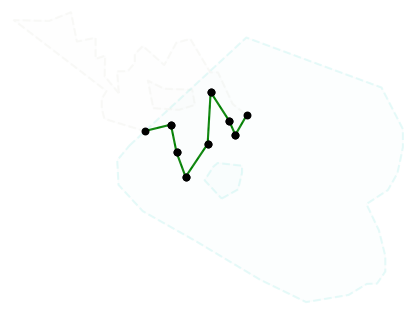

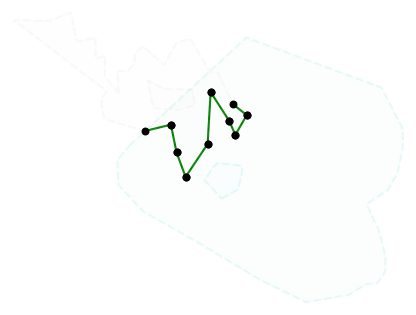

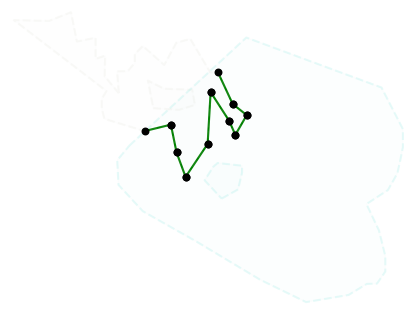

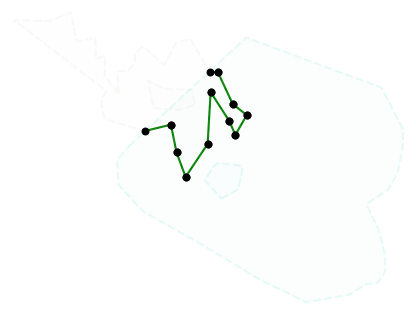

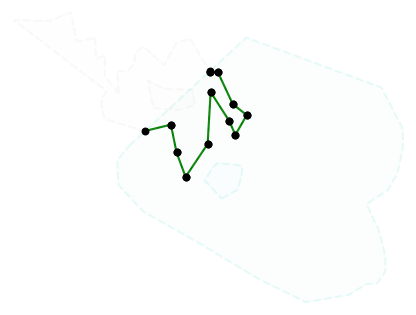

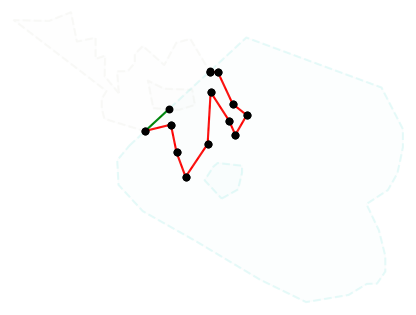

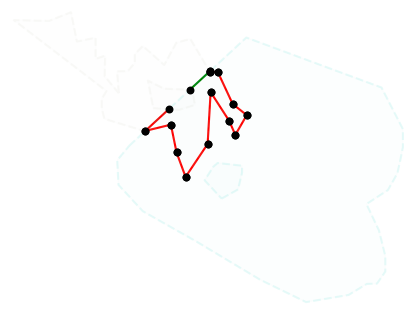

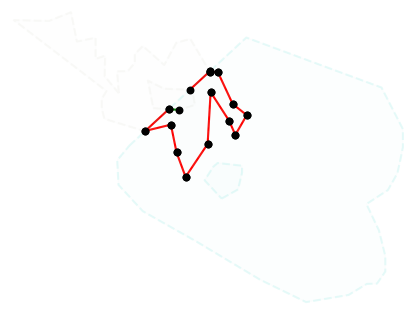

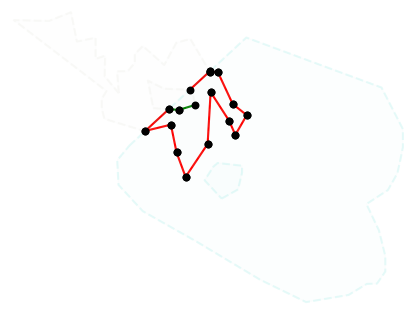

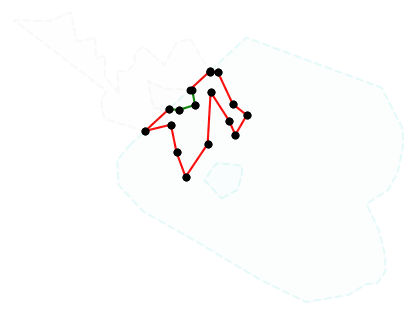

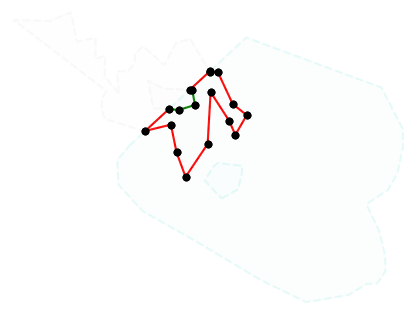

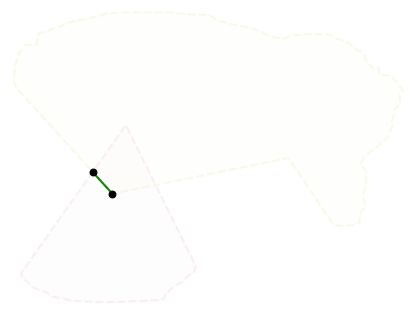

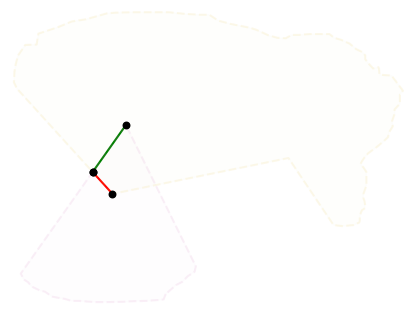

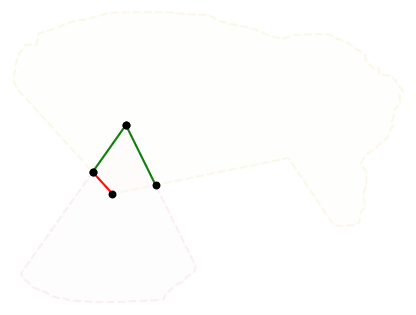

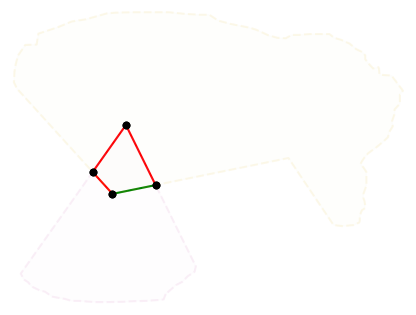

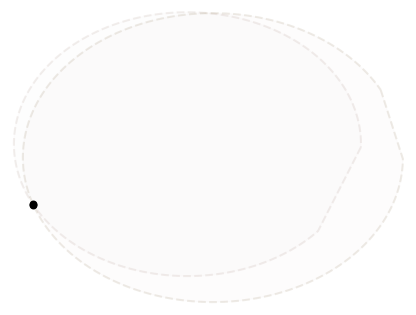

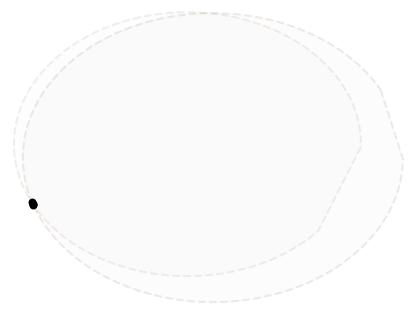

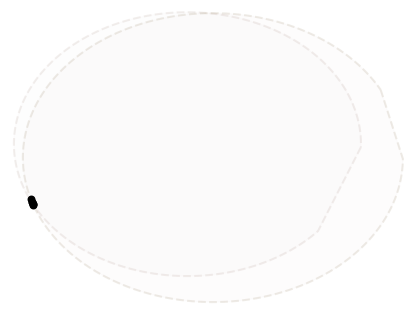

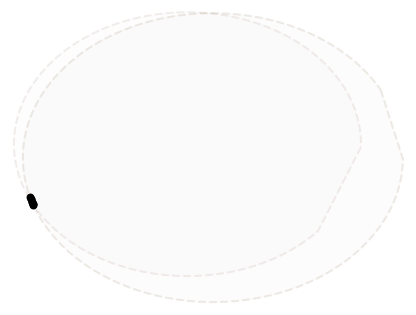

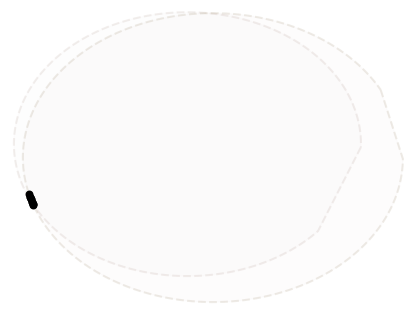

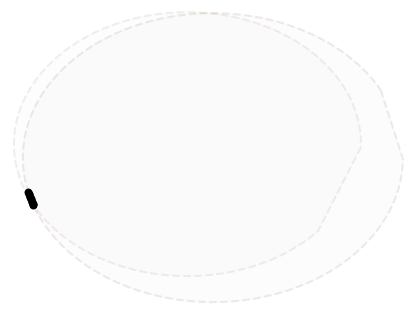

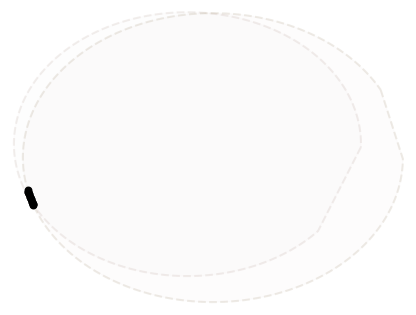

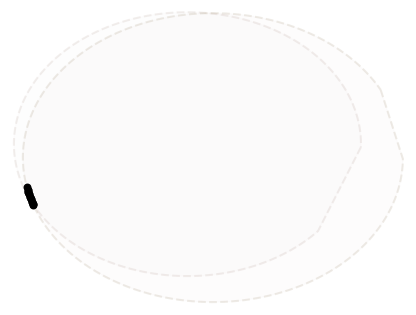

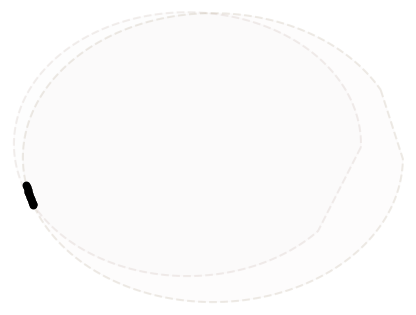

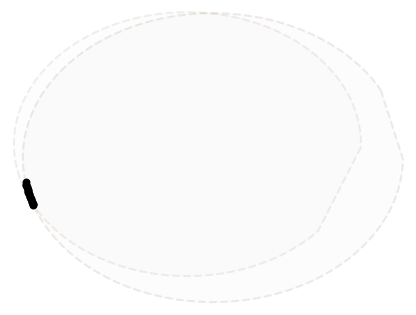

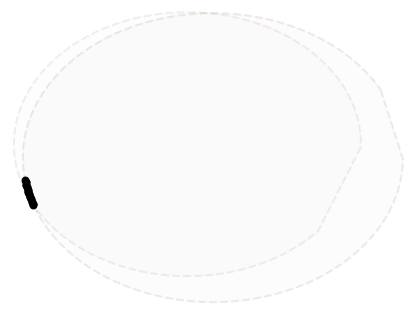

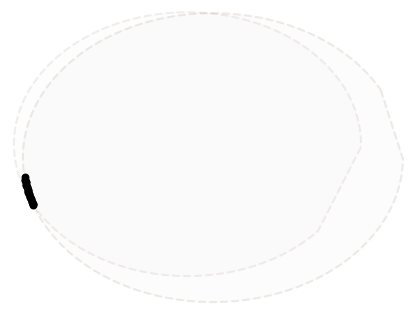

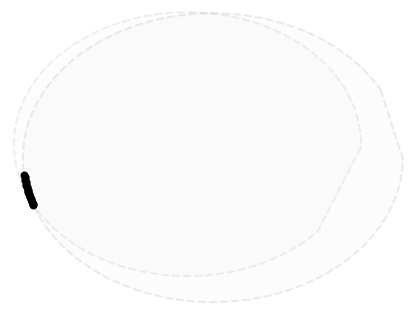

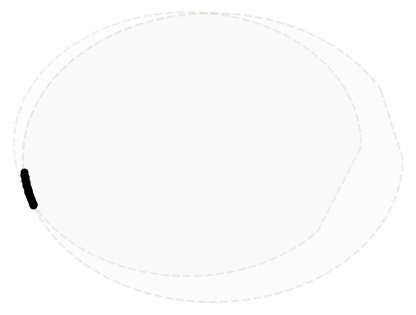

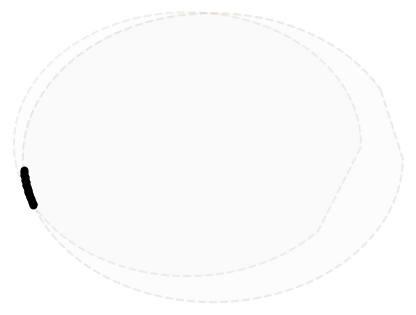

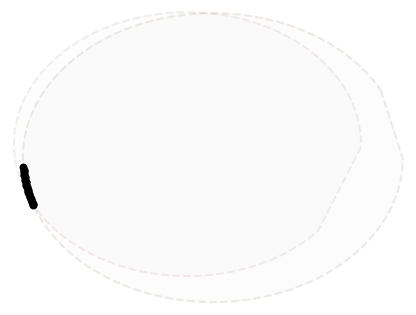

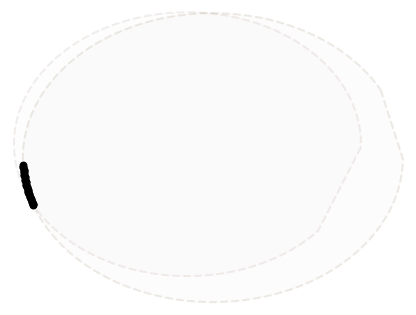

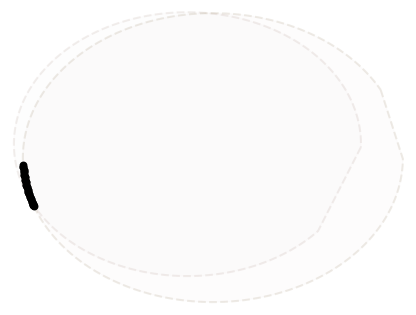

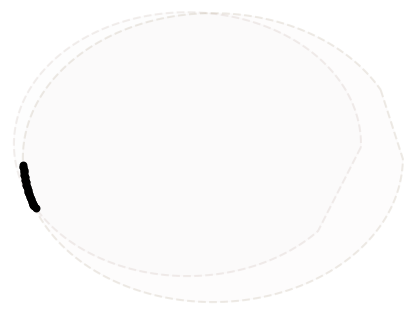

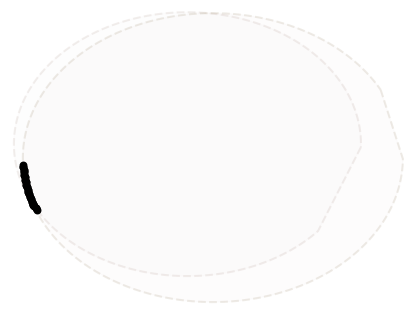

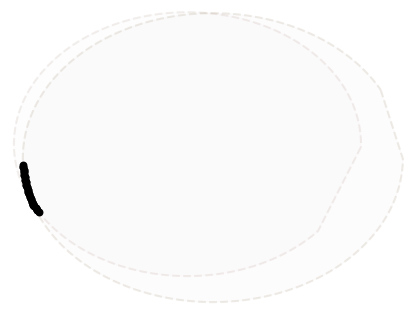

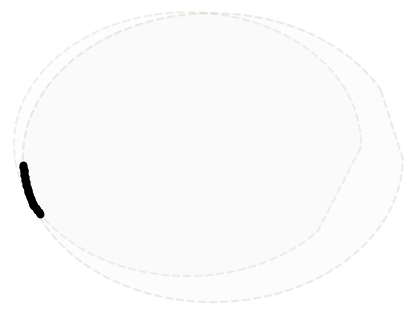

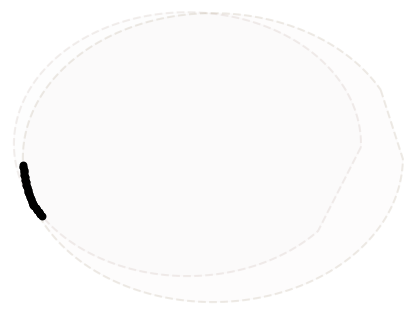

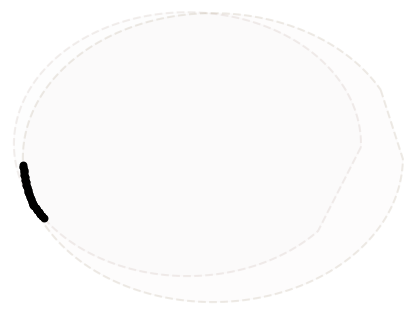

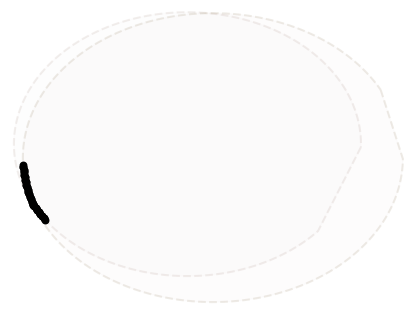

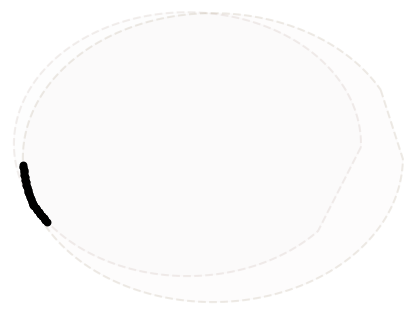

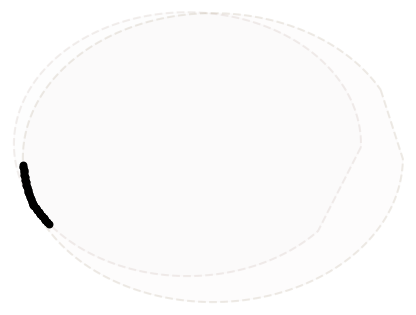

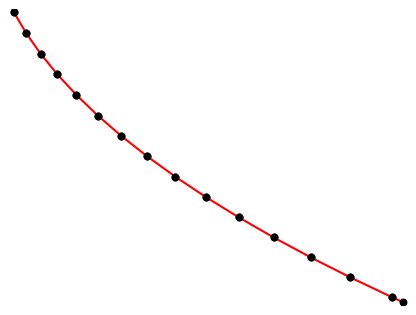

In [5]:
total = 0
passed = 0
stats_df = pd.DataFrame(columns=['common_bbox', 'get_chunks_idxs_within_bounds', 'nbr_recieved_chks', 'nbr_total_chks', 'get_chk', 'total_time', "dataset", "passed", "Context"])

def evaluate_dataset(data, plot, total, passed, dataset_name):
    for g1, g2 in data:
        #is_intersecting, intersect_points = binary_intersection(g1, g2)

        _, b1 = fpd.compress(g1)
        _, b2 = fpd.compress(g2)
        exp_boolean = shapely.intersects(g1, g2)
        #is_intersecting = chunk_bbox_is_intersecting((b1, b2), exp_boolean, True)
        is_intersecting = fpd.is_intersecting((b1, b2))[1]

        exp_shape = shapely.intersection(g1, g2)
        stats, intersection = chunk_bbox_intersection((b1, b2), exp_boolean, True, get_stats=True)
        if plot and exp_boolean: # Now only plotting intersecting shapes
            if False: # Plot chunks?
                plot_chunks_bounds(b1, True, avoid_show=True)
                plot_chunks_bounds(b2, True, avoid_create_frame=True, avoid_show=True)
            geoms = (g1, g2)
            for g in geoms:
                plot_geometry(g, SHOW_GEOMETRIES)
                plot_geometry_bbox(g, SHOW_BOUNDING_BOXES)
                plot_coordinates(g, SHOW_COORDINATES)
            
            plot_common_bbox(geoms, SHOW_COMMON_BOUNDING_BOX)
            #plot_intersecting_points(intersect_points, legends, SHOW_INTERSECTING_POINTS)

            if SHOW_COORDINATES or SHOW_GEOMETRIES or SHOW_INTERSECTING_POINTS or SHOW_COMMON_BOUNDING_BOX or SHOW_BOUNDING_BOXES:
                plt.title("Intersection Plot: " + ('True' if is_intersecting else 'False'))
                plt.show()


            PLOT_RESULTING_INTERSECTION = True
            if is_intersecting and PLOT_RESULTING_INTERSECTION:
                create_canvas(zoom=1.1, no_frame=True)
                for g in geoms:
                    plot_geometry(g, SHOW_GEOMETRIES, alpha=0.2, fill_alpha=0.2)
                    plot_coordinates(g, SHOW_COORDINATES, size=1)
                
                plot_geometry(intersection, fill_alpha=0.6, hatch=True)
                plot_coordinates(intersection, size=10)
                #plt.title("Intersecting Shape")
                plt.show()

        total += 1

        #Add statistics to stats_df
        if SHOW_STATS:

            stats.append(dataset_name)
            stats.append(exp_shape.equals(intersection))
            
            s1, s2 = (shapely.get_num_coordinates(g1), shapely.get_num_coordinates(g2))
            sz = "MIXED"
            if s1 < LARGE_THRESHOLD and s2 < LARGE_THRESHOLD:
                sz = "SMALL"
            elif s1 >= LARGE_THRESHOLD and s2 >= LARGE_THRESHOLD:
                sz = "LARGE"
            
            stats.append(sz)
            stats_df.loc[len(stats_df)] = stats

        
        if is_intersecting == exp_boolean and exp_shape.equals(intersection):
            passed += 1
            print("PASSED")
        #     if not exp_shape.is_empty:
        #         create_canvas()
        #         plot_geometry(g1,alpha=0.2)
        #         plot_geometry(g2,alpha=0.2)
        #         #plot_geometry(exp_shape, solid=False)
        #         plot_geometry(intersection)
        #         plot_coordinates(intersection)
        #         plt.show()
            
        else:
            print("FAILED")

        #     print("Above FAILED!")
        #     print('Expected shape:', exp_shape)
        #     print('Returned shape:', intersection)
        #     create_canvas()
        #     plot_geometry(g1,alpha=0.2, fill_alpha=0.2, solid=False)
        #     plot_geometry(g2,alpha=0.2, fill_alpha=0.2, solid=False)
        #     #plot_geometry(exp_shape, solid=False)
        #     plot_geometry(intersection, fill_alpha=1.0)
        #     plot_coordinates(intersection)
        #     plt.show()
        if total % 100 == 0:
            print(f"Passed {passed} of {total}. Total in set: {len(data)}")
    return total, passed

#total, passed = evaluate_dataset(manual_data, False, total, passed, "Manual") # Second param: PLOT?
total, passed = evaluate_dataset(special_cases, True, total, passed, "Special Case")
#total, passed = evaluate_dataset(world_data, False, total, passed, "World")
#total, passed = evaluate_dataset(lund_data, False, total, passed, "Lund")

print(f'Done. Passed: {passed} of {total}.')
if SHOW_STATS:
    #Calculate decompression and intersection time fraction
    stats_df["chk_fraction_unfolded"] = stats_df["nbr_recieved_chks"].div(stats_df.nbr_total_chks, axis=0)
    chk_fractions_df = stats_df[["chk_fraction_unfolded", "dataset", "Context"]]
    print("\Fractions of chunk unfolded:")
    display(chk_fractions_df.groupby(['Context','dataset']).mean())


    stats_df[["common_bbox", "get_chunks_idxs_within_bounds", "get_chk"]] = stats_df[["common_bbox", "get_chunks_idxs_within_bounds", "get_chk"]].div(stats_df.total_time, axis=0)
    stats_df['intersection'] = stats_df.apply(lambda x: 1 - x['common_bbox'] - x['get_chunks_idxs_within_bounds'] - x['get_chk'], axis=1)
    stats_df['decomp'] = stats_df.apply(lambda x: x['common_bbox'] + x['get_chunks_idxs_within_bounds'] + x['get_chk'], axis=1)
    exec_fractions_df = stats_df[["decomp", "intersection", "dataset", "Context"]]
    print("\nExecetion time distribution:")
    display(exec_fractions_df.groupby(['Context','dataset']).mean())
#POLYGON ((6.5 6.5, 8 5, 4 4, 6.5 6.5))